In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from feature_engine import imputation
from feature_engine import encoding

# pipeline utility
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures

# hyper-parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# metrics to evaluate models
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# linear models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor

# neighbors models
from sklearn.neighbors import KNeighborsRegressor

# tree models
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

In [2]:
house_data = pd.read_csv('../data/train.csv', index_col='Id')
X = house_data.drop(labels='SalePrice', axis=1)
Y = house_data['SalePrice']
X.shape, Y.shape

((1460, 79), (1460,))

In [3]:
cv = RepeatedKFold(n_splits=6, n_repeats=12, random_state=64)

In [4]:
base_pipeline = Pipeline(steps=[('most_miss_cat', imputation.CategoricalImputer(variables=['Alley',
                                                                                           'FireplaceQu',
                                                                                           'PoolQC',
                                                                                           'Fence',
                                                                                           'MiscFeature'])),
                                ('least_miss_cat', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                  seed='observation',
                                                                                  variables=['GarageCond',
                                                                                             'GarageType',
                                                                                             'GarageFinish',
                                                                                             'GarageQual',
                                                                                             'BsmtExposure',
                                                                                             'BsmtFinType2',
                                                                                             'BsmtCond',
                                                                                             'BsmtQual',
                                                                                             'BsmtFinType1',
                                                                                             'MasVnrType',
                                                                                             'Electrical'])),
                                ('least_miss_num', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                  seed='observation',
                                                                                  variables=['LotFrontage',
                                                                                             'GarageYrBlt',
                                                                                             'MasVnrArea'])),
                                ('encode', encoding.OrdinalEncoder(
                                    variables=X.select_dtypes(include=object).columns.to_list())),
                                ('scaling', RobustScaler()),
                                ('transform', QuantileTransformer(output_distribution='normal')),
                                ('scale_to_range', MinMaxScaler()),
                                ('feature_selection', SelectKBest(score_func=mutual_info_regression,
                                                                  k=20))]
                         )

In [5]:
X_ = base_pipeline.fit_transform(X, Y)
train_x, test_x, train_y, test_y = train_test_split(X_, Y, test_size=0.2, random_state=48)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1168, 20), (292, 20), (1168,), (292,))

### Lasso model hyper-parameter tuning

In [6]:
L1_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                           ('lasso', Lasso())])
L1_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures()), ('lasso', Lasso())],
 'verbose': False,
 'poly': PolynomialFeatures(),
 'lasso': Lasso(),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': 'deprecated',
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [9]:
l1_grid = {'lasso__alpha': np.exp(np.random.normal(0, 5, 25)),
           'lasso__max_iter': np.random.randint(1000, 6580, 4)
           }

l1_grid_search = GridSearchCV(estimator=L1_model,
                              param_grid=l1_grid,
                              scoring={'r2': make_scorer(r2_score),
                                       'me': make_scorer(max_error)
                                       },
                              refit='r2',
                              n_jobs=-1,
                              cv=cv)

l1_grid_search.fit(train_x, train_y)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.397e+09, tolerance: 7.405e+08
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.36240559e+00, 5.09650935e-04, 1.36518178e-03, 2.34427570e+00,
       3.94148561e-02, 1.19543881e-03, 1.34546427e+03, 1.39763998e-01,
       8.91411678e+00, 3.89664653e+00, 2.22187391e+00, 7.39601408e+02,
       6.53411636e-02, 4.27754032e-03, 4.99826970e-02, 5.16190912e+01,
       2.01002633e-01, 5.62079557e+00, 1.40125439e-02, 3.13203511e-01,
       6.56560299e+00, 9.63509355e+01, 5.52455953e-03, 3.22991033e-03,
       1.28071478e+01]),
                         'lasso__max_iter': array([3411, 5502, 5985, 2687])},
             refit='r2',
             scoring={'me': make_scorer(max_error),
                      'r2': make_scorer(r2_score)})

In [12]:
l1_grid_search.best_params_, l1_grid_search.best_score_

({'lasso__alpha': 12.807147786982478, 'lasso__max_iter': 2687},
 0.8582179183379455)

In [17]:
temp_l1_cv_result = pd.DataFrame(l1_grid_search.cv_results_)
temp_l1_cv_result.to_pickle('../data/cv_results/l1_cv_result.pkl')

### Ridge model hyper-parameter tuning

In [8]:
L2_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                           ('ridge', Ridge())])
L2_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures()), ('ridge', Ridge())],
 'verbose': False,
 'poly': PolynomialFeatures(),
 'ridge': Ridge(),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': 'deprecated',
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [10]:
l2_grid = {'ridge__alpha': np.exp(np.random.normal(0, 5, 25)),
           'ridge__max_iter': np.random.randint(1000, 6580, 4)
           }

l2_grid_search = GridSearchCV(estimator=L2_model,
                              param_grid=l2_grid,
                              scoring={'r2': make_scorer(r2_score),
                                       'me': make_scorer(max_error)
                                       },
                              refit='r2',
                              n_jobs=-1,
                              cv=cv)

l2_grid_search.fit(train_x, train_y)

GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.31126344e+02, 3.89911045e-01, 1.57619448e+00, 1.25777725e+00,
       3.31674693e-02, 3.75486593e-03, 9.82609112e-03, 6.72825549e+05,
       1.38327667e+03, 1.18260102e+06, 2.23209131e+00, 3.55747948e+00,
       3.69327214e+00, 6.40218447e+01, 4.37709079e-01, 4.89488876e-03,
       1.28600521e-01, 2.07991834e-03, 5.37884562e-01, 1.55284967e+01,
       6.75642940e-03, 2.62140261e+01, 3.40807308e-01, 1.51681554e-02,
       2.47807479e+00]),
                         'ridge__max_iter': array([6055, 5819, 1835, 3678])},
             refit='r2',
             scoring={'me': make_scorer(max_error),
                      'r2': make_scorer(r2_score)})

In [11]:
l2_grid_search.best_params_, l2_grid_search.best_score_

({'ridge__alpha': 0.5378845624526254, 'ridge__max_iter': 6055},
 0.8602809816793933)

In [18]:
temp_l2_cv_result = pd.DataFrame(l2_grid_search.cv_results_)
temp_l2_cv_result.to_pickle('../data/cv_results/l2_cv_result.pkl')

### Elastic net model hyper-parameter tuning

In [2]:
elasticNet_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                   ('elasticNet', ElasticNet())])
elasticNet_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=3)),
  ('elasticNet', ElasticNet())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=3),
 'elasticNet': ElasticNet(),
 'poly__degree': 3,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'elasticNet__alpha': 1.0,
 'elasticNet__copy_X': True,
 'elasticNet__fit_intercept': True,
 'elasticNet__l1_ratio': 0.5,
 'elasticNet__max_iter': 1000,
 'elasticNet__normalize': 'deprecated',
 'elasticNet__positive': False,
 'elasticNet__precompute': False,
 'elasticNet__random_state': None,
 'elasticNet__selection': 'cyclic',
 'elasticNet__tol': 0.0001,
 'elasticNet__warm_start': False}

In [8]:
iteration = 64
elasticNet_grid = {'elasticNet__alpha': np.exp(np.random.normal(0, 5, 12)),
                   'elasticNet__max_iter': np.random.randint(1000, 5000, 4),
                   'elasticNet__l1_ratio': np.linspace(0, 1, 9)
                   }

elasticNet_grid_search = RandomizedSearchCV(estimator=elasticNet_model,
                                            param_distributions=elasticNet_grid,
                                            scoring={'r2': make_scorer(r2_score),
                                                     'me': make_scorer(max_error)
                                                     },
                                            refit='r2',
                                            n_jobs=-1,
                                            cv=cv)

elasticNet_grid_search.fit(train_x, train_y)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+11, tolerance: 7.405e+08
  model = cd_fast.enet_coordinate_descent(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=3)),
                                             ('elasticNet', ElasticNet())]),
                   n_jobs=-1,
                   param_distributions={'elasticNet__alpha': array([1.39233193e-01, 3.81326433e-02, 7.55360589e+02, 6.97434347e-01,
       6.97421159e+00, 9.03409319e+00, 5.36540303e+00, 4.26474421e+02,
       1.15198366e+02, 7.54807993e+02, 3.78955228e+01, 1.73782951e-03]),
                                        'elasticNet__l1_ratio': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                                        'elasticNet__max_iter': array([2788, 3849, 2977, 2358])},
                   refit='r2',
                   scoring={'me': make_scorer(max_error),
                            'r2': make_scorer(r2_score)})

In [9]:
elasticNet_grid_search.best_params_, elasticNet_grid_search.best_score_

({'elasticNet__max_iter': 2977,
  'elasticNet__l1_ratio': 0.25,
  'elasticNet__alpha': 0.03813264333947848},
 0.8604811592475424)

In [10]:
temp_elasticNet_cv_result = pd.DataFrame(elasticNet_grid_search.cv_results_)
temp_elasticNet_cv_result.to_pickle('../data/cv_results/elasticNet_cv_result.pkl')

### Stochastic gradient decent

In [7]:
SDG_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                            ('SDG', SGDRegressor())])
SDG_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures()), ('SDG', SGDRegressor())],
 'verbose': False,
 'poly': PolynomialFeatures(),
 'SDG': SGDRegressor(),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'SDG__alpha': 0.0001,
 'SDG__average': False,
 'SDG__early_stopping': False,
 'SDG__epsilon': 0.1,
 'SDG__eta0': 0.01,
 'SDG__fit_intercept': True,
 'SDG__l1_ratio': 0.15,
 'SDG__learning_rate': 'invscaling',
 'SDG__loss': 'squared_error',
 'SDG__max_iter': 1000,
 'SDG__n_iter_no_change': 5,
 'SDG__penalty': 'l2',
 'SDG__power_t': 0.25,
 'SDG__random_state': None,
 'SDG__shuffle': True,
 'SDG__tol': 0.001,
 'SDG__validation_fraction': 0.1,
 'SDG__verbose': 0,
 'SDG__warm_start': False}

In [8]:
sdg_iteration = 100

SDG_grid = {'SDG__alpha': np.exp(np.random.normal(0, 5, 12)),
            'SDG__max_iter': np.random.randint(1000, 10000, 10),
            'SDG__l1_ratio': np.linspace(0, 1, 9),
            'SDG__penalty': ['l2', 'l1', 'elasticnet'],
            'SDG__learning_rate': ['constant', 'optimal', 'adaptive']
            }

SDG_grid_search = RandomizedSearchCV(estimator=SDG_model,
                                     param_distributions=SDG_grid,
                                     scoring={'r2': make_scorer(r2_score),
                                              'me': make_scorer(max_error)
                                              },
                                     refit='r2',
                                     n_jobs=-1,
                                     n_iter=sdg_iteration,
                                     cv=cv)

SDG_grid_search.fit(train_x, train_y)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1509: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('SDG', SGDRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'SDG__alpha': array([3.71135299e+01, 2.73985790e+00, 1.17096216e+01, 1.56372274e-01,
       6.94351611e+01, 1.33771364e+00, 4.00236601e+05, 4.00155904e-02,
       5.86957500...1, 5.84622268e+04, 2.44566533e-01]),
                                        'SDG__l1_ratio': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                                        'SDG__learning_rate': ['constant',
                                                               'optimal',
                                                               'adaptive'],
                                        'SDG__max_iter': array([7039, 5594, 4742, 7416, 4149, 8988, 9774, 2297, 7699, 3373

In [9]:
SDG_grid_search.best_params_, SDG_grid_search.best_score_

({'SDG__penalty': 'l1',
  'SDG__max_iter': 4742,
  'SDG__learning_rate': 'adaptive',
  'SDG__l1_ratio': 0.5,
  'SDG__alpha': 5.869575002873918e-05},
 0.8567255105682428)

In [10]:
temp_SDG_cv_result = pd.DataFrame(SDG_grid_search.cv_results_)
temp_SDG_cv_result.to_pickle('../data/cv_results/SDG_cv_result.pkl')

### K nearest neighbors model hyper-parameter tuning

In [17]:
KNN_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                            ('KNN', KNeighborsRegressor())])
KNN_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=4)),
  ('KNN', KNeighborsRegressor())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=4),
 'KNN': KNeighborsRegressor(),
 'poly__degree': 4,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'KNN__algorithm': 'auto',
 'KNN__leaf_size': 30,
 'KNN__metric': 'minkowski',
 'KNN__metric_params': None,
 'KNN__n_jobs': None,
 'KNN__n_neighbors': 5,
 'KNN__p': 2,
 'KNN__weights': 'uniform'}

In [21]:
KNN_iteration = 24

KNN_grid = {'KNN__algorithm': ['brute', 'kd_tree', 'ball_tree'],
            'KNN__leaf_size': np.random.randint(30, 100, 12),
            'KNN__n_neighbors': np.random.randint(7, 51, 12),
            }

KNN_grid_search = RandomizedSearchCV(estimator=KNN_model,
                                     param_distributions=KNN_grid,
                                     scoring={'r2': make_scorer(r2_score),
                                              'me': make_scorer(max_error)
                                              },
                                     refit='r2',
                                     n_jobs=-1,
                                     n_iter=KNN_iteration,
                                     cv=cv)

KNN_grid_search.fit(train_x, train_y)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=4)),
                                             ('KNN', KNeighborsRegressor())]),
                   n_iter=24, n_jobs=-1,
                   param_distributions={'KNN__algorithm': ['brute', 'kd_tree',
                                                           'ball_tree'],
                                        'KNN__leaf_size': array([77, 77, 83, 69, 37, 90, 42, 44, 64, 66, 39, 55]),
                                        'KNN__n_neighbors': array([46, 48, 37, 29, 30, 46, 11, 13, 41, 24, 20, 25])},
                   refit='r2',
                   scoring={'me': make_scorer(max_error),
                            'r2': make_scorer(r2_score)})

In [22]:
KNN_grid_search.best_params_, KNN_grid_search.best_score_

({'KNN__n_neighbors': 11, 'KNN__leaf_size': 77, 'KNN__algorithm': 'ball_tree'},
 0.7853041378821608)

In [23]:
temp_KNN_cv_result = pd.DataFrame(KNN_grid_search.cv_results_)
temp_KNN_cv_result.to_pickle('../data/cv_results/KNN_cv_result.pkl')

### Decision tree model hyper-parameter tuning

In [6]:
DT_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                           ('DT', DecisionTreeRegressor())])
DT_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=4)),
  ('DT', DecisionTreeRegressor())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=4),
 'DT': DecisionTreeRegressor(),
 'poly__degree': 4,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'DT__ccp_alpha': 0.0,
 'DT__criterion': 'squared_error',
 'DT__max_depth': None,
 'DT__max_features': None,
 'DT__max_leaf_nodes': None,
 'DT__min_impurity_decrease': 0.0,
 'DT__min_samples_leaf': 1,
 'DT__min_samples_split': 2,
 'DT__min_weight_fraction_leaf': 0.0,
 'DT__random_state': None,
 'DT__splitter': 'best'}

In [8]:
DT_grid = {'DT__splitter': ['best', 'random'],
           'DT__max_depth': np.random.randint(6, 30, 12)
           }

DT_grid_search = GridSearchCV(estimator=DT_model,
                              param_grid=DT_grid,
                              scoring={'r2': make_scorer(r2_score),
                                       'me': make_scorer(max_error),
                                       'mse': make_scorer(mean_squared_error)
                                       },
                              refit='mse',
                              return_train_score=True,
                              n_jobs=-1,
                              cv=cv)

DT_grid_search.fit(train_x, train_y)

GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                                       ('DT', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'DT__max_depth': array([ 8,  6, 20, 16, 28,  7, 15, 27, 13, 12, 13, 11]),
                         'DT__splitter': ['best', 'random']},
             refit='mse', return_train_score=True,
             scoring={'me': make_scorer(max_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)})

In [9]:
DT_grid_search.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('DT', DecisionTreeRegressor(max_depth=27, splitter='random'))])

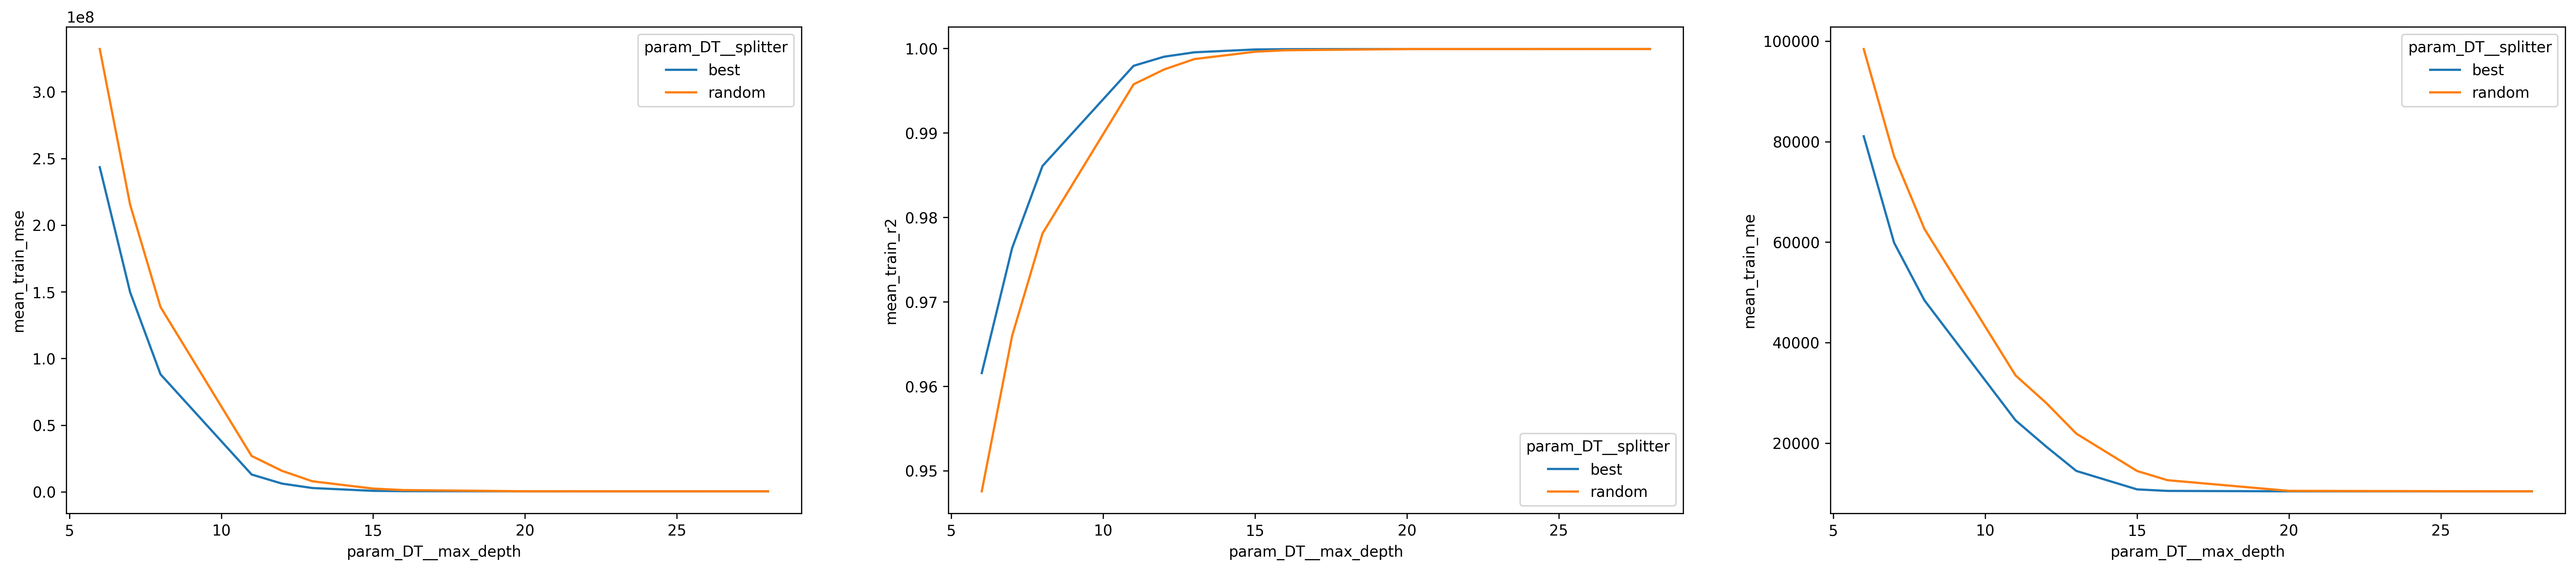

In [12]:
temp_DT_depth = pd.DataFrame(DT_grid_search.cv_results_)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[30, 6], dpi=300)
sns.lineplot(x='param_DT__max_depth', y='mean_train_mse', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[0])
sns.lineplot(x='param_DT__max_depth', y='mean_train_r2', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[1])
sns.lineplot(x='param_DT__max_depth', y='mean_train_me', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[2])
plt.savefig('graphs/decision_tree_depth_train.png')
plt.show()

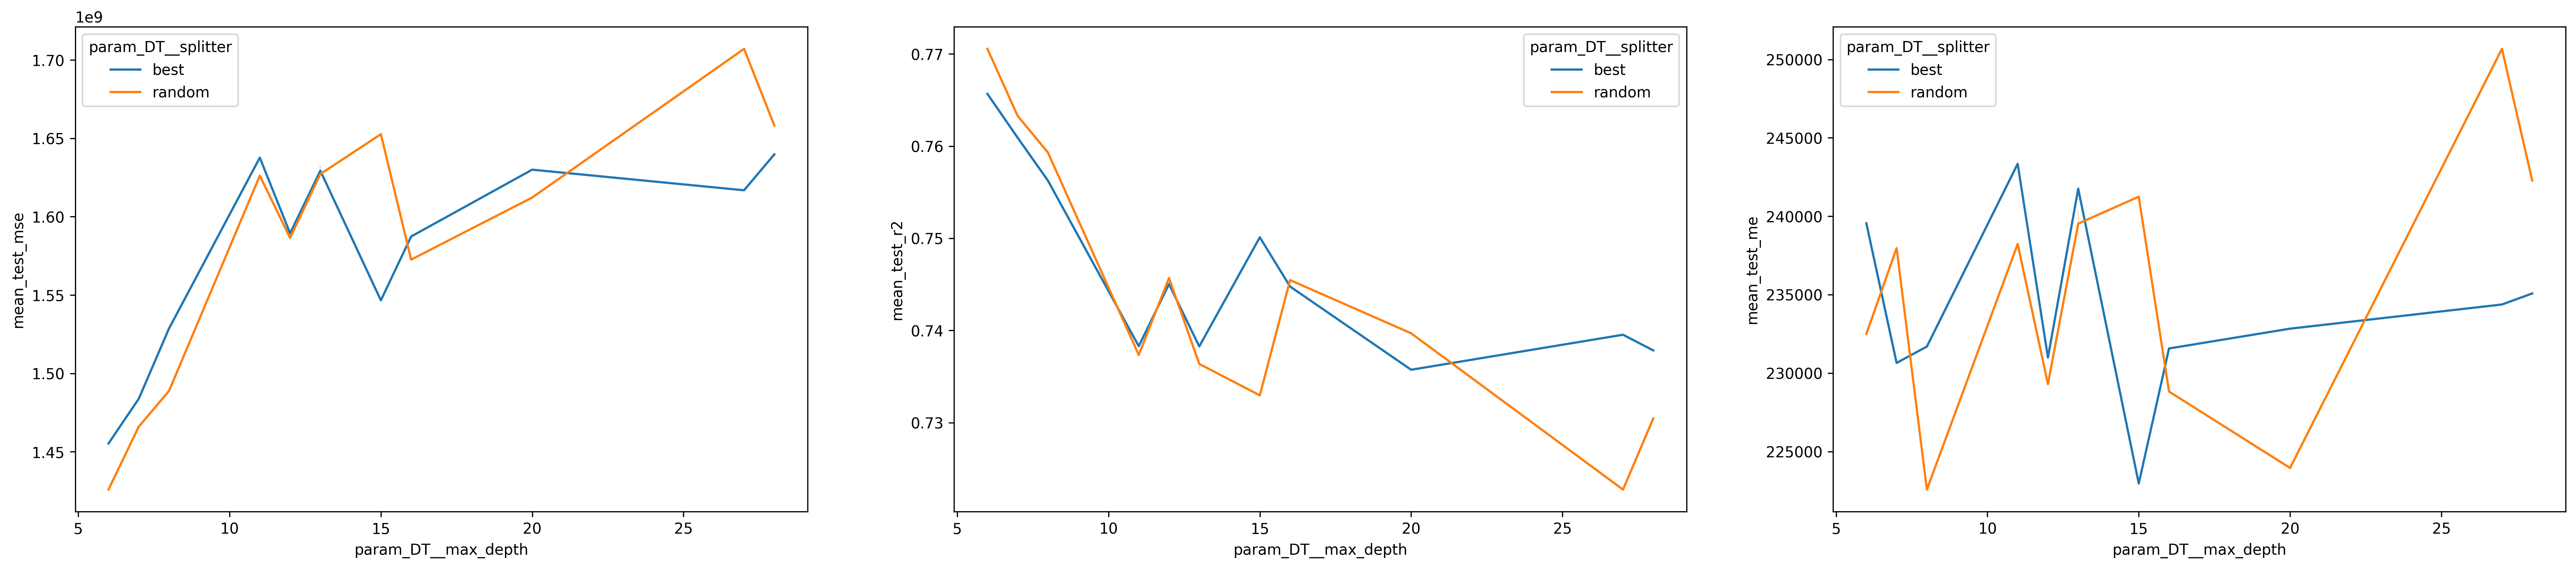

In [13]:
temp_DT_depth = pd.DataFrame(DT_grid_search.cv_results_)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[30, 6], dpi=300)
sns.lineplot(x='param_DT__max_depth', y='mean_test_mse', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[0])
sns.lineplot(x='param_DT__max_depth', y='mean_test_r2', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[1])
sns.lineplot(x='param_DT__max_depth', y='mean_test_me', hue='param_DT__splitter', data=temp_DT_depth, ax=axes[2])
plt.savefig('graphs/decision_tree_depth_test.png')
plt.show()

In [14]:
DT_iteration = 12

DT_grid = {'DT__splitter': ['best', 'random'],
           'DT__max_depth': np.random.randint(5, 35, 10),
           'DT__min_samples_leaf': np.random.randint(12, 50, 10),
           'DT__max_leaf_nodes': np.random.randint(10, 60, 10),
           'DT__max_features': ['auto', 'sqrt', 'log2'],
           'DT__min_samples_split': np.random.randint(24, 100, 10),
           'DT__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
           'DT__min_impurity_decrease': [0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2]}

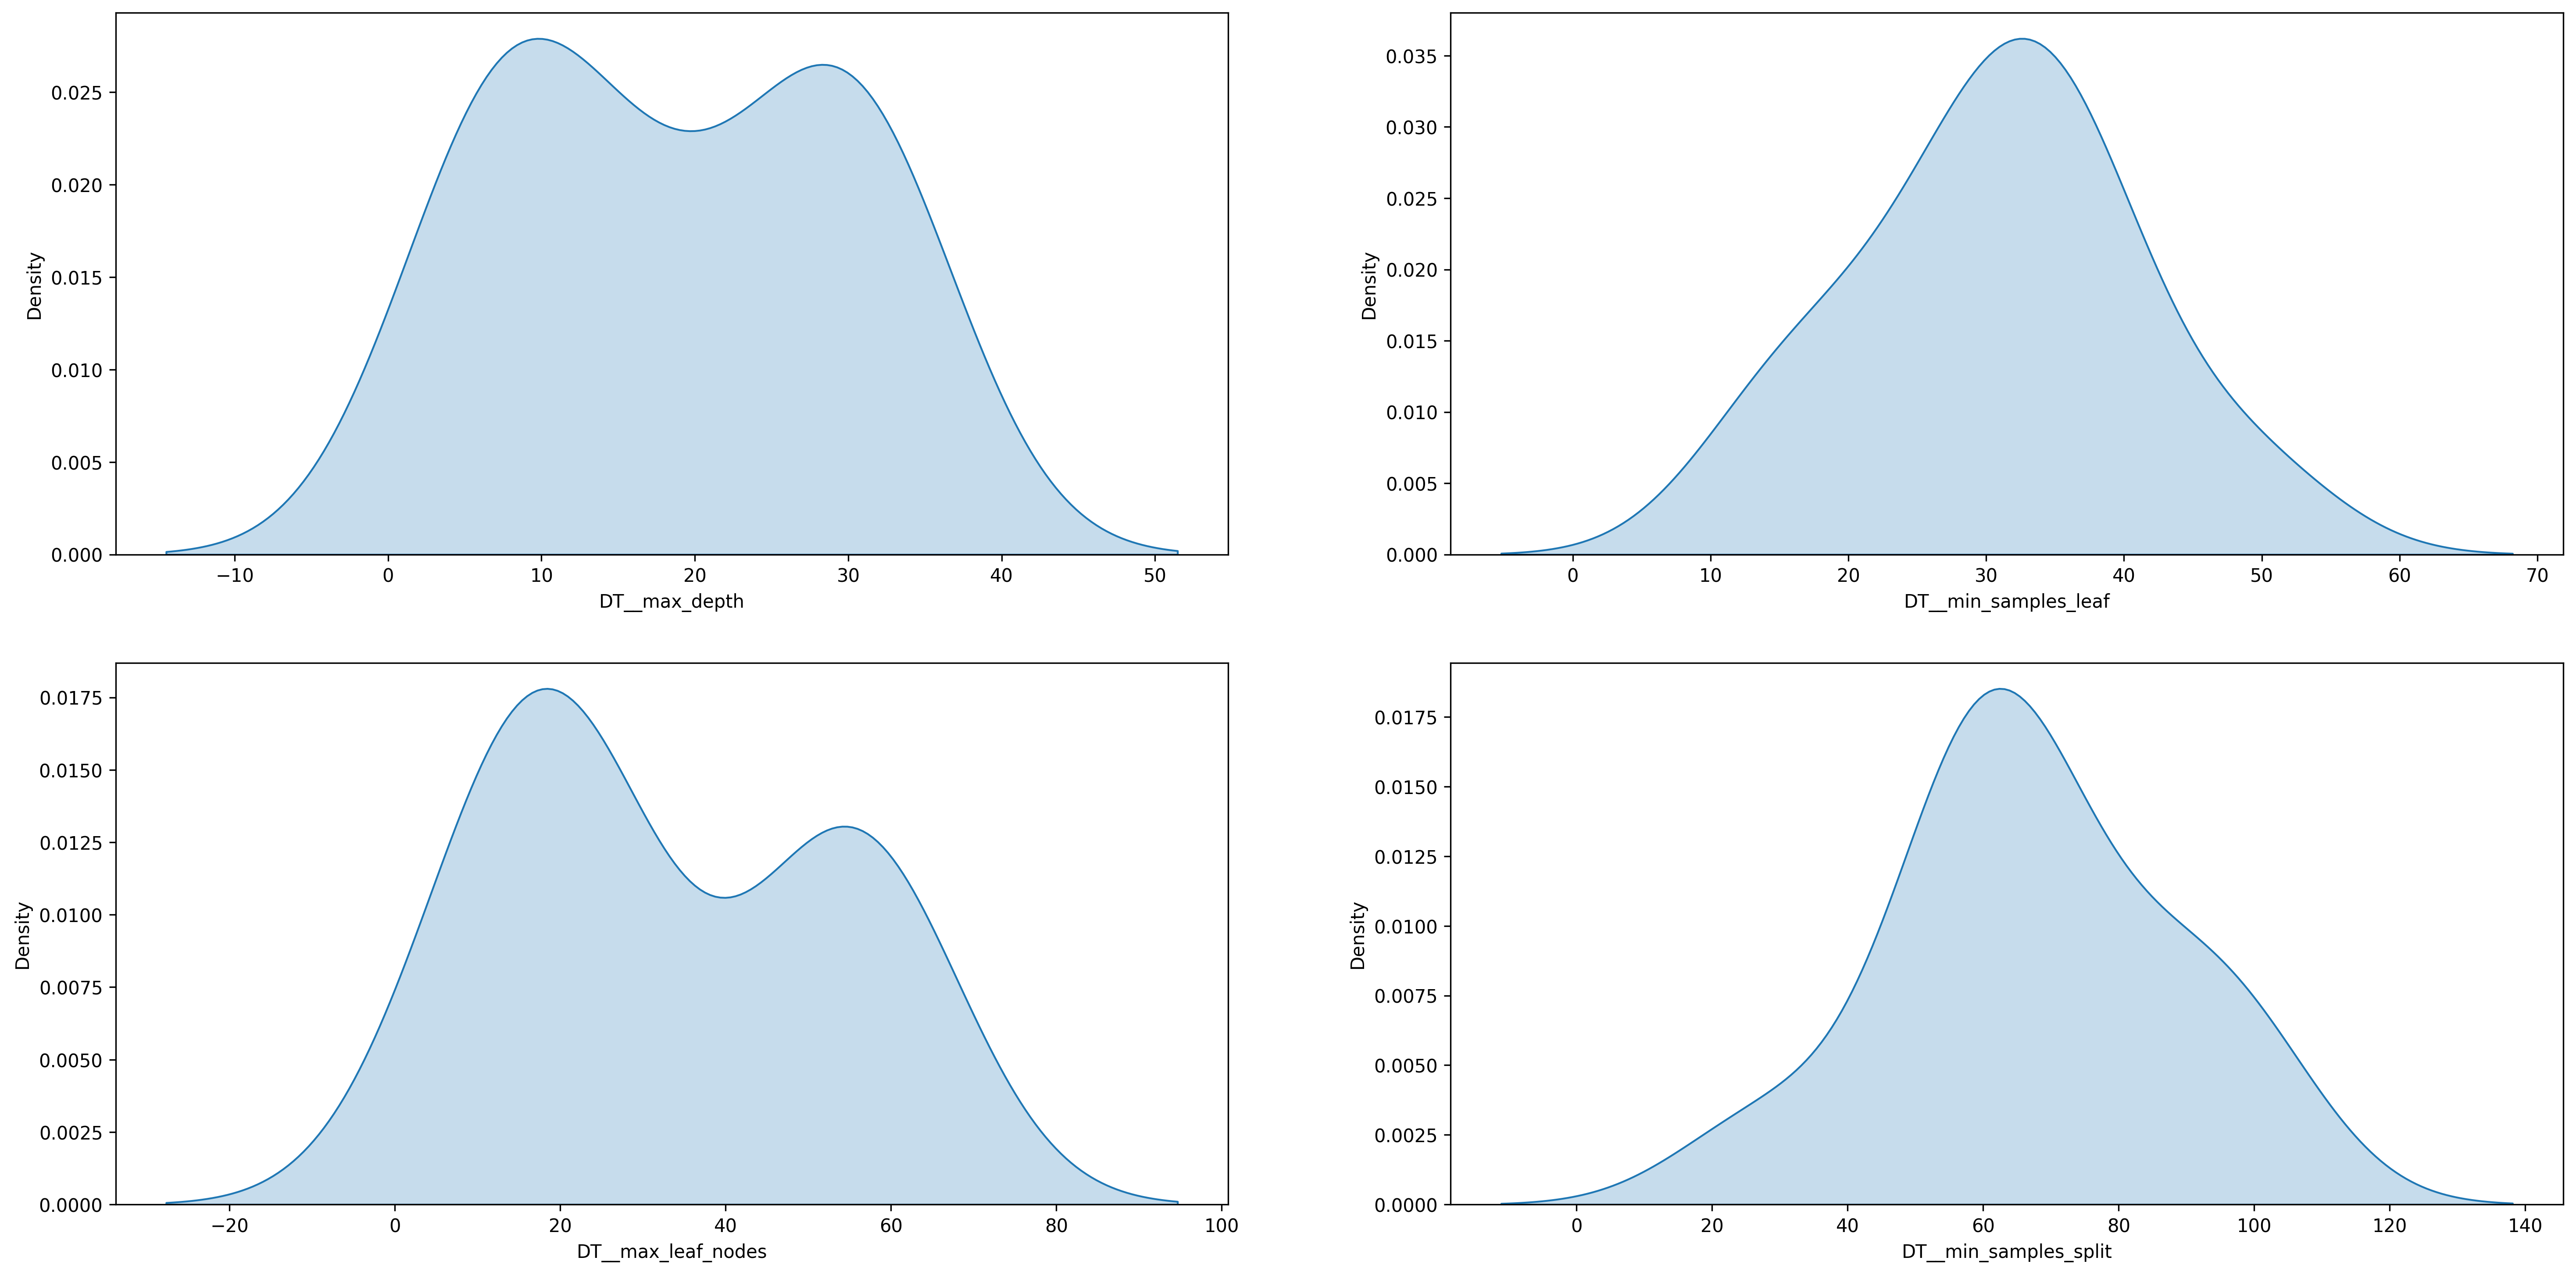

In [17]:
distributions = ['DT__max_depth', 'DT__min_samples_leaf', 'DT__max_leaf_nodes', 'DT__min_samples_split']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[24, 12], dpi=300)
axes = axes.ravel()

for i in range(len(axes)):
    sns.kdeplot(x=DT_grid[distributions[i]], shade=True, ax=axes[i])
    axes[i].set_xlabel(distributions[i])

plt.savefig('graphs/param_distribution.png')
plt.show()

In [18]:
DT_grid_search = RandomizedSearchCV(estimator=DT_model,
                                    param_distributions=DT_grid,
                                    scoring={'r2': make_scorer(r2_score),
                                             'me': make_scorer(max_error),
                                             'mse': make_scorer(mean_squared_error, greater_is_better=False)},
                                    refit='mse',
                                    n_jobs=-1,
                                    n_iter=DT_iteration,
                                    return_train_score=True,
                                    cv=cv)

DT_grid_search.fit(train_x, train_y)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=4)),
                                             ('DT', DecisionTreeRegressor())]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'DT__criterion': ['squared_error',
                                                          'friedman_mse',
                                                          'absolute_error',
                                                          'poisson'],
                                        'DT__max_depth': array([ 6, 16, 30, 20, 29,  9, 31,  8, 31,  7]),
                                        'DT__max...
                                        'DT__min_impurity_decrease': [0.0,
                                                                      0.0005,
                                                              

In [19]:
DT_grid_search.best_params_, DT_grid_search.best_score_

({'DT__splitter': 'random',
  'DT__min_samples_split': 56,
  'DT__min_samples_leaf': 34,
  'DT__min_impurity_decrease': 0.05,
  'DT__max_leaf_nodes': 21,
  'DT__max_features': 'auto',
  'DT__max_depth': 9,
  'DT__criterion': 'absolute_error'},
 -1312764140.9573617)

In [20]:
temp_DT_cv_result = pd.DataFrame(DT_grid_search.cv_results_)
temp_DT_cv_result.to_pickle('../data/cv_results/DT_cv_result.pkl')

In [21]:
temp_DT_cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_DT__splitter,param_DT__min_samples_split,param_DT__min_samples_leaf,param_DT__min_impurity_decrease,param_DT__max_leaf_nodes,param_DT__max_features,...,split65_test_mse,split66_test_mse,split67_test_mse,split68_test_mse,split69_test_mse,split70_test_mse,split71_test_mse,mean_test_mse,std_test_mse,rank_test_mse
0,0.344592,0.093224,0.064684,0.021848,random,56,14,0.15,10,log2,...,-2.592756e+09,-2.081265e+09,-1.251543e+09,-2.337816e+09,-2.129235e+09,-3.395073e+09,-2.647524e+09,-2.080245e+09,5.367724e+08,10
1,0.341970,0.026346,0.067685,0.008017,random,68,31,0.2,13,sqrt,...,-2.377959e+09,-1.225277e+09,-1.500751e+09,-1.219326e+09,-1.328239e+09,-2.508104e+09,-1.812973e+09,-1.629051e+09,4.422417e+08,6
2,0.336089,0.018408,0.065774,0.005402,random,56,26,0.15,10,sqrt,...,-2.144457e+09,-1.236407e+09,-1.013634e+09,-1.434878e+09,-1.522794e+09,-2.542962e+09,-1.962934e+09,-1.670846e+09,4.487570e+08,7
3,6.563297,0.754242,0.063566,0.015815,random,57,26,0.0,13,auto,...,-2.340358e+09,-1.373290e+09,-1.324967e+09,-1.340126e+09,-1.578541e+09,-2.636700e+09,-2.074057e+09,-1.793277e+09,3.810719e+08,9
4,0.414690,0.087215,0.087393,0.028778,random,99,38,0.15,54,sqrt,...,-2.050066e+09,-1.826246e+09,-1.318791e+09,-1.301565e+09,-1.594151e+09,-2.732718e+09,-2.305534e+09,-1.685619e+09,4.621957e+08,8
5,0.413957,0.097530,0.085520,0.028731,random,94,18,0.15,17,log2,...,-2.381872e+09,-2.287243e+09,-1.649978e+09,-2.837381e+09,-2.295823e+09,-4.076901e+09,-3.330025e+09,-2.448067e+09,5.105509e+08,12
6,2.667058,0.085189,0.057623,0.008165,random,62,34,0.1,13,auto,...,-1.794644e+09,-1.199779e+09,-1.156369e+09,-9.013047e+08,-1.130679e+09,-2.424958e+09,-1.691579e+09,-1.396222e+09,4.000718e+08,3
7,7.783722,0.471857,0.054073,0.011243,best,68,34,0.05,56,auto,...,-1.866717e+09,-1.052452e+09,-1.152672e+09,-9.797922e+08,-1.438546e+09,-2.056950e+09,-1.706753e+09,-1.334151e+09,3.865947e+08,2
8,0.319683,0.043864,0.064299,0.009212,best,68,27,0.0,54,log2,...,-2.251630e+09,-1.117798e+09,-1.039073e+09,-1.307857e+09,-1.168384e+09,-2.240779e+09,-1.562729e+09,-1.554007e+09,4.385232e+08,4
9,0.318745,0.019683,0.065574,0.007707,random,62,38,0.1,10,log2,...,-2.229969e+09,-1.574244e+09,-1.456592e+09,-1.803220e+09,-1.984847e+09,-2.872581e+09,-3.007752e+09,-2.138811e+09,5.683307e+08,11


In [32]:
DT_grid_search.best_params_

{'DT__splitter': 'random',
 'DT__min_samples_split': 56,
 'DT__min_samples_leaf': 34,
 'DT__min_impurity_decrease': 0.05,
 'DT__max_leaf_nodes': 21,
 'DT__max_features': 'auto',
 'DT__max_depth': 9,
 'DT__criterion': 'absolute_error'}

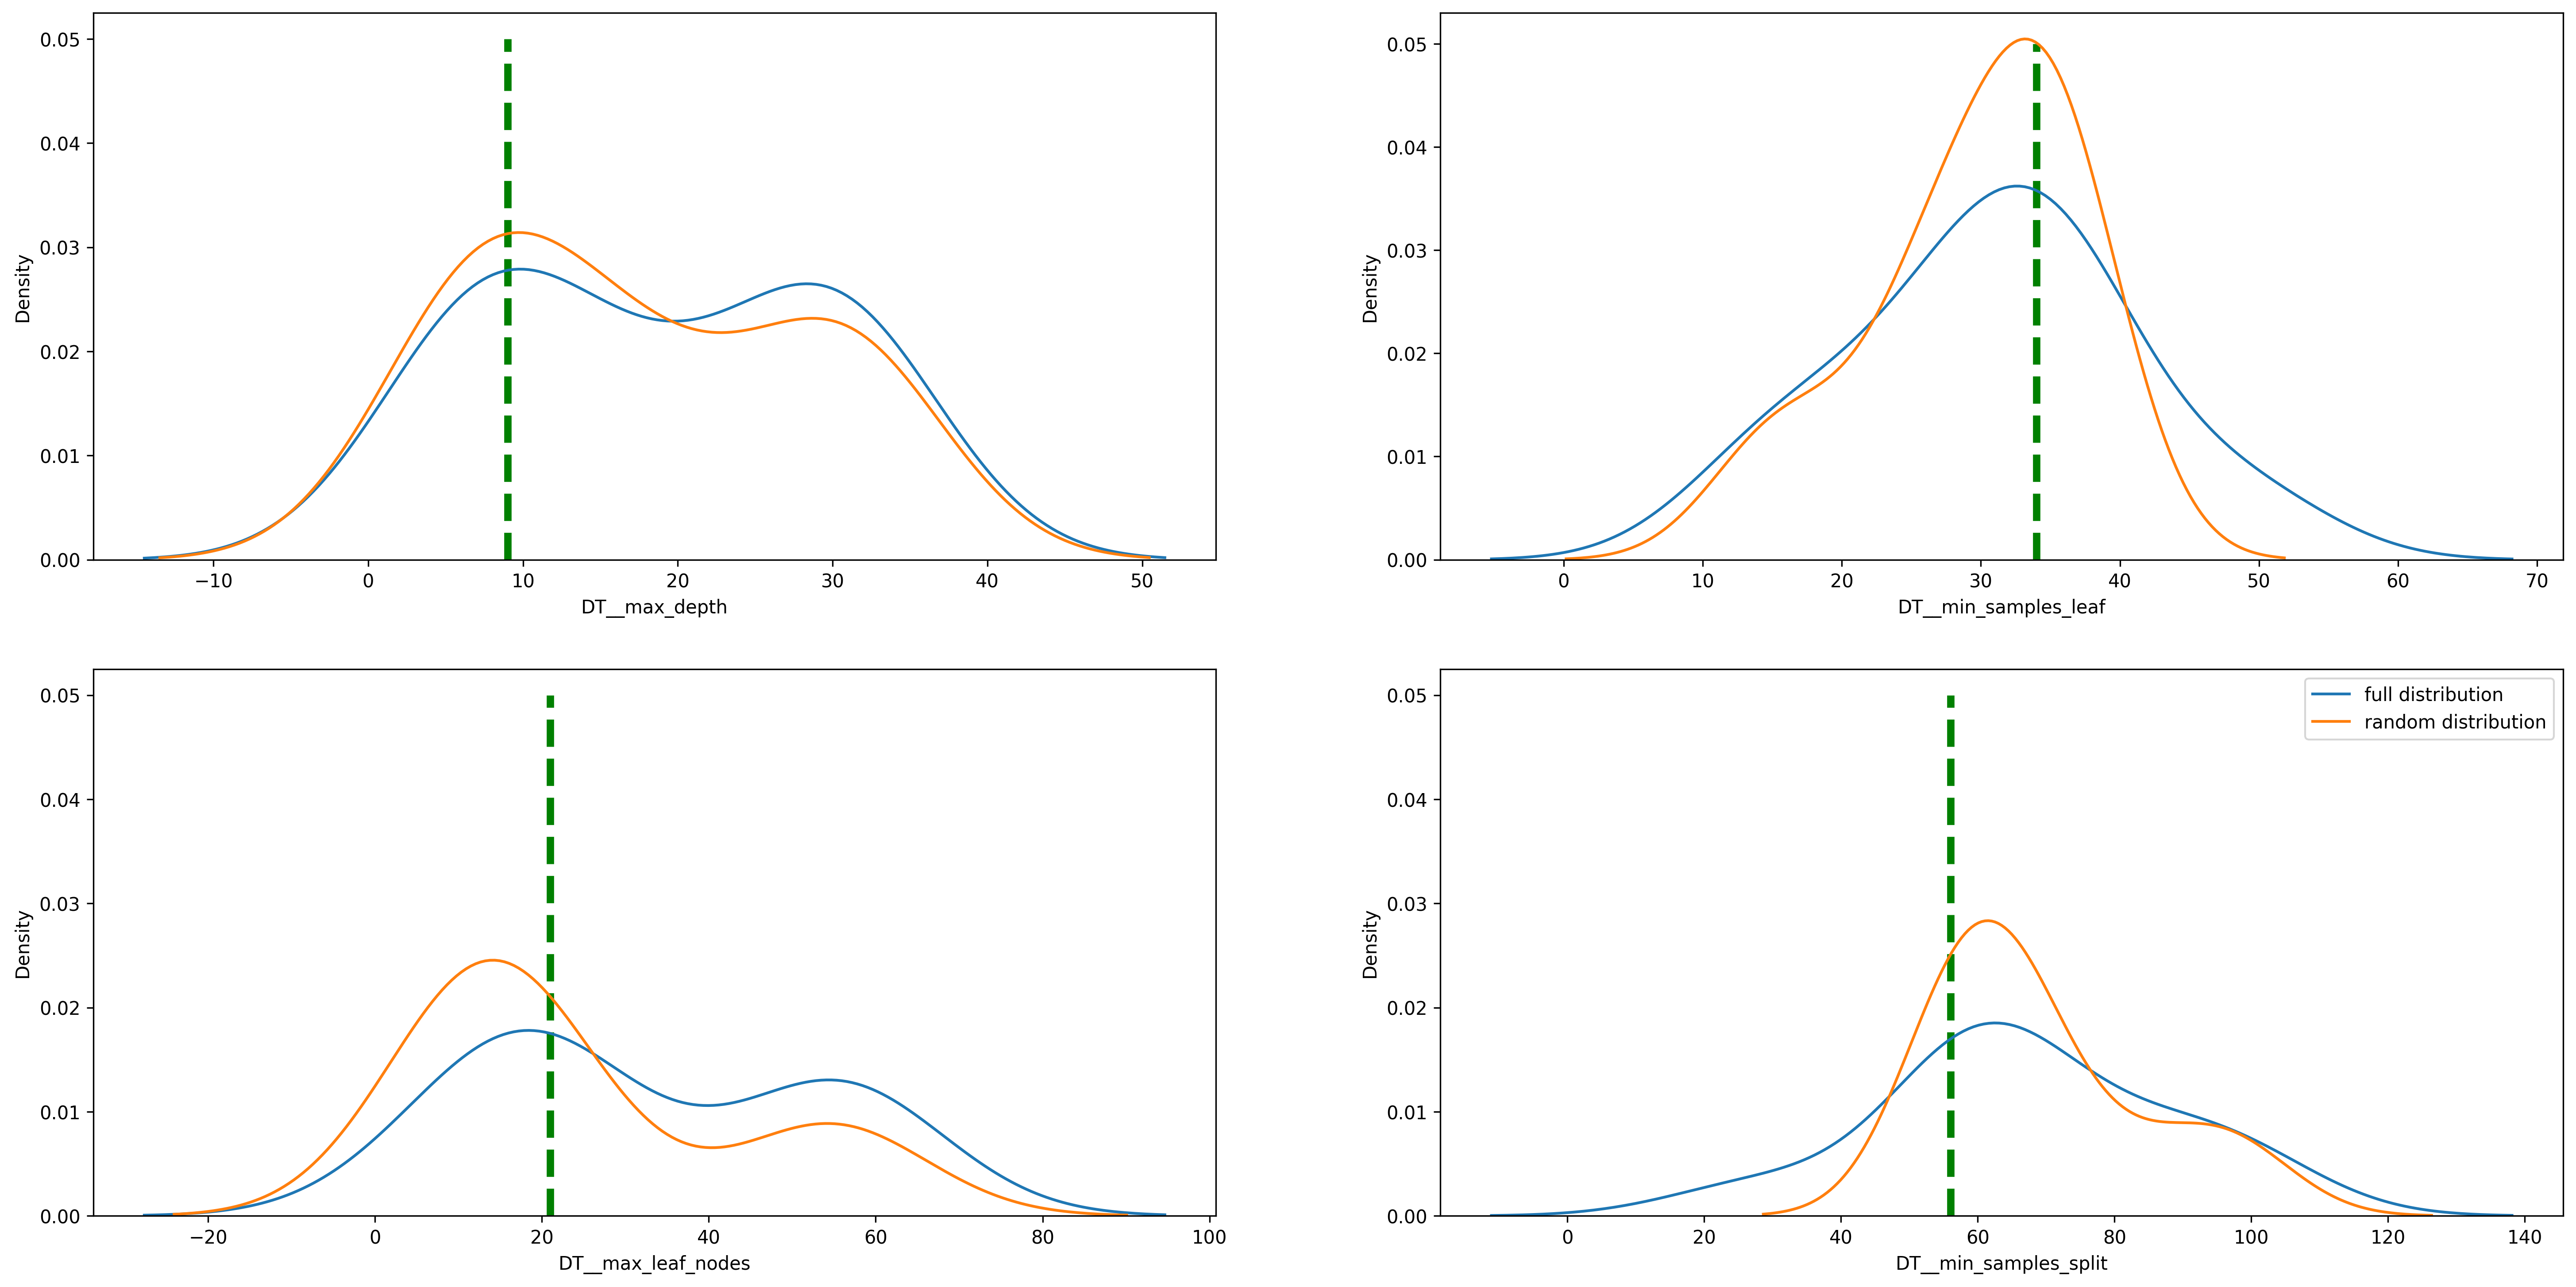

In [36]:
param_distributions = ['param_DT__max_depth', 'param_DT__min_samples_leaf', 'param_DT__max_leaf_nodes',
                       'param_DT__min_samples_split']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[24, 12], dpi=300)
axes = axes.ravel()

for i in range(len(axes)):
    sns.kdeplot(x=DT_grid[distributions[i]], shade=False, ax=axes[i], label='full distribution')
    axes[i].set_xlabel(distributions[i])

for i in range(len(axes)):
    sns.kdeplot(x=temp_DT_cv_result[param_distributions[i]], shade=False, ax=axes[i], label='random distribution')
    axes[i].set_xlabel(distributions[i])
    axes[i].vlines(x=DT_grid_search.best_params_[distributions[i]],
                   ymin=0.0, ymax=0.05, linestyles='--', linewidth=4, color='green')

plt.legend()
plt.savefig('graphs/param_distribution_compare.png')
plt.show()

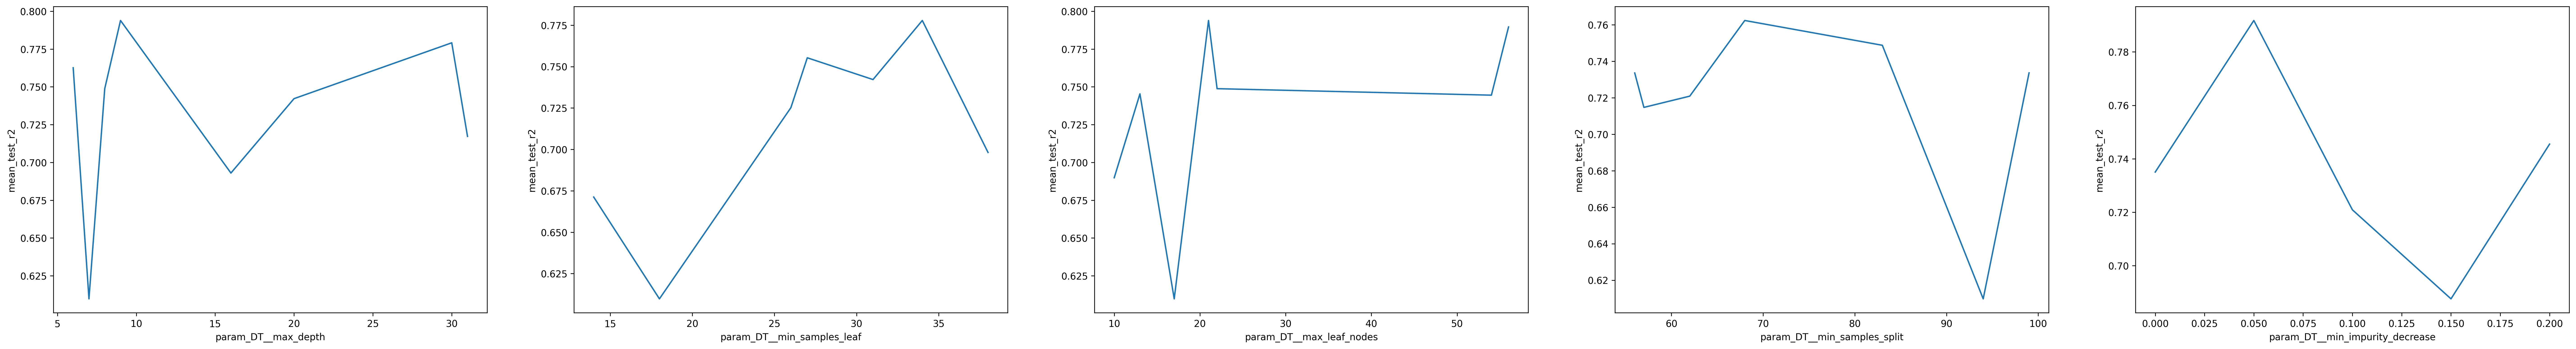

In [31]:
parameters = ['param_DT__max_depth', 'param_DT__min_samples_leaf', 'param_DT__max_leaf_nodes',
              'param_DT__min_samples_split', 'param_DT__min_impurity_decrease']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[48, 6], dpi=300)
axes = axes.ravel()

for i in range(len(axes)):
    sns.lineplot(x=temp_DT_cv_result[parameters[i]],
                 y=temp_DT_cv_result['mean_test_r2'],
                 err_style=None,
                 ax=axes[i])

plt.savefig('graphs/DT_gridSearch_test_metrics.png')
plt.show()

### Extra tree model hyper-parameter tuning

In [7]:
ET_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                           ('ET', ExtraTreeRegressor())])
ET_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=4)),
  ('ET', ExtraTreeRegressor())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=4),
 'ET': ExtraTreeRegressor(),
 'poly__degree': 4,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'ET__ccp_alpha': 0.0,
 'ET__criterion': 'squared_error',
 'ET__max_depth': None,
 'ET__max_features': 'auto',
 'ET__max_leaf_nodes': None,
 'ET__min_impurity_decrease': 0.0,
 'ET__min_samples_leaf': 1,
 'ET__min_samples_split': 2,
 'ET__min_weight_fraction_leaf': 0.0,
 'ET__random_state': None,
 'ET__splitter': 'random'}

In [12]:
ET_iteration = 128

ET_grid = {'ET__max_depth': np.random.randint(25, 100, 12),
           'ET__min_samples_split': np.random.randint(20, 90, 12),
           'ET__min_samples_leaf': np.random.randint(14, 100, 12),
           'ET__max_features': ['auto', 'sqrt', 'log2'],
           'ET__ccp_alpha': np.random.randint(0, 12, 6)
           }

ET_grid_search = RandomizedSearchCV(estimator=ET_model,
                                    param_distributions=ET_grid,
                                    scoring={'r2': make_scorer(r2_score),
                                             'me': make_scorer(max_error)
                                             },
                                    refit='r2',
                                    n_jobs=-1,
                                    n_iter=ET_iteration,
                                    cv=cv)

ET_grid_search.fit(train_x, train_y)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=4)),
                                             ('ET', ExtraTreeRegressor())]),
                   n_iter=128, n_jobs=-1,
                   param_distributions={'ET__ccp_alpha': array([ 5,  6, 11,  2,  2,  8]),
                                        'ET__max_depth': array([67, 57, 31, 94, 82, 27, 59, 90, 35, 98, 82, 66]),
                                        'ET__max_features': ['auto', 'sqrt',
                                                             'log2'],
                                        'ET__min_samples_leaf': array([75, 34, 40, 15, 91, 52, 26, 46, 97, 26, 63, 41]),
                                        'ET__min_samples_split': array([64, 38, 53, 49, 73, 28, 61, 58, 21, 20, 49, 27])},
                   refit='r2',
                   scoring={'me': make_score

In [13]:
ET_grid_search.best_params_, ET_grid_search.best_score_

({'ET__min_samples_split': 53,
  'ET__min_samples_leaf': 26,
  'ET__max_features': 'auto',
  'ET__max_depth': 66,
  'ET__ccp_alpha': 6},
 0.7979352579753282)

In [14]:
temp_ET_cv_result = pd.DataFrame(ET_grid_search.cv_results_)
temp_ET_cv_result.to_pickle('../data/cv_results/ET_cv_result.pkl')